In [1]:
#Assignment 9
#Joint assimilation of navigation data coming from different sources
#Team 12
#Yaroslav Savotin, Elizaveta Pestova, Selamawit Asfaw
#Skoltech, 2023

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def generate_Xt(x0, sigma_a, Fi, G, N):  
    ax = np.random.normal(0, np.sqrt(sigma_a), size = (1, 1, N))
    ay = np.random.normal(0, np.sqrt(sigma_a), size =(1, 1, N))
    
    A = np.zeros((2, 1, N))
    for i in range(N):
        A[0,0,i] = ax[0][0][i]
        A[1,0,i] = ay[0][0][i]
    
    Xt = np.zeros((4, 1, N))
    Xt[:, :, 0] = x0
    for i in range(1, N):
        Xt[:, :, i] = np.dot(Fi,Xt[:, :, i-1]) + np.dot(G,A[:, :, i-1])
    return Xt


def generate_DB(Xt,sigmaD, sigmaB_1Obs, sigmaB_2Obs, N):
    D = np.zeros((1, 1, N))
    Beta = np.zeros((1, 1, N))
    Dm = np.zeros((1, 1, N))
    Betam1 = np.zeros((1, 1, N))
    Betam2 = np.zeros((1, 1, N))
      
    nuD = np.random.normal(0, np.sqrt(sigmaD), size =(1, 1, N))
    nuB_1 = np.random.normal(0, np.sqrt(sigmaB_1Obs), size =(1, 1, N))
    nuB_2 = np.random.normal(0, np.sqrt(sigmaB_2Obs), size =(1, 1, N))
    
    
    for i in range(N):
        D[:, :, i] = np.sqrt(Xt[0, 0, i]**2 + Xt[2, 0, i]**2)
        Beta[:, :, i] = np.arctan(Xt[0, 0, i] / Xt[2, 0, i])
        Dm[:, :, i] = D[:, :, i] + nuD[:, :, i]
        Betam1[:, :, i] = Beta[:, :, i] + nuB_1[:, :, i]
        Betam2[:, :, i] = Beta[:, :, i] + nuB_2[:, :, i]
        
    return D, Beta, Dm, Betam1, Betam2

In [3]:
def Extended_kalmanFilter_1(R, X0, P0, Dm, Betam, Fi, Q, N):
    
    Zm = np.zeros((2, 1, N)) #measurement in !!!polar coordinates!!!
    for i in range(N):
        Zm[0, :, i] = Dm[:, :, i]
        Zm[1, :, i] = Betam[:, :, i]
    
    Xf = np.zeros((4, 1, N)) #Filtration of state vector
    Pf = np.zeros((4, 4, N)) #Filtration error covariance matrix
    Xp = np.zeros((4, 1, N)) #Prediction of state vector
    Pp = np.zeros((4, 4, N)) #Prediction error covariance matrix
    
    Df = np.zeros((1, 1, N))
    Betaf = np.zeros((1, 1, N))
    Dp = np.zeros((1, 1, N))
    Betap = np.zeros((1, 1, N))
    
    #coordinates in Cartesian coordinate system
    Xm = np.zeros((1, 1, N)) 
    Ym = np.zeros((1, 1, N))
    
    K = np.zeros((4, 2, N)) #Filter gain
    dh = np.zeros((2, 4, N)) #Derivative
    h = np.zeros((2, 1, N)) #Nonlinear function
    
    #Initial conditions
    Df[:, :, 0] = Dm[:, :, 0]
    Betaf[:, :, 0] = Betam[:, :, 0]
    Dp[:, :, 0] = Dm[:, :, 0]
    Betap[:, :, 0] = Betam[:, :, 0]
    
    Pf[:, :, 0] = P0
    Xf[:, :, 0] = X0
    
    #Transformation from polar to Cartesian coordinate system
    Xm[:, :, 0] = Dm[:, :, 0][0][0] * np.sin(Betam[:, :, 0])[0][0]
    Ym[:, :, 0] = Dm[:, :, 0][0][0] * np.cos(Betam[:, :, 0])[0][0]

    for i in range(N-1):
        #Prediction (extrapolation)
        Xp[:, :, i+1] = np.dot(Fi, Xf[:, :, i])
        
            #range D, azimuth Beta at every extrapolation step 
        Dp[:, :, i+1] = np.sqrt((Xp[0, :, i+1]**2) + (Xp[2, :, i+1]**2))
        Betap[:, :, i+1] = np.arctan(Xp[0, :, i+1] / Xp[2, :, i+1])
        
            #Transformation from polar to Cartesian coordinate system
        Xm[:, :, i+1] = Dp[:, :, i+1][0][0] * np.sin(Betap[:, :, i+1])[0][0]
        Ym[:, :, i+1] = Dp[:, :, i+1][0][0] * np.cos(Betap[:, :, i+1])[0][0]
        
            #Derivative
        dh[:, :, i+1] = np.array([[(Xp[0, 0, i+1]/np.sqrt(Xp[0, 0, i+1]**2+Xp[2, 0, i+1]**2)), 0, (Xp[2, 0, i+1]/np.sqrt(Xp[0, 0, i+1]**2+Xp[2, 0, i+1]**2)), 0],
                            [(Xp[2, 0, i+1]/(Xp[0, 0, i+1]**2+Xp[2, 0, i+1]**2)), 0, (-Xp[0, 0, i+1]/(Xp[0, 0, i+1]**2+Xp[2, 0, i+1]**2)), 0]])
        
        Pp[:, :, i+1] = np.dot(np.dot(Fi, Pf[:, :, i]), np.transpose(Fi)) + Q
        
        h[0, :, i+1] = Dp[:, :, i+1]
        h[1, :, i+1] = Betap[:, :, i+1]
        
        #Filtration
            #Filter gain
        K[:, :, i+1] = np.dot(np.dot(Pp[:, :, i+1], np.transpose(dh[:, :, i+1])), np.linalg.inv(np.dot(np.dot(dh[:, :, i+1], Pp[:, :, i+1]), np.transpose(dh[:, :, i+1])) + R))
            #Improved estimate by incorporating a new measurement
        Xf[:, :, i+1] = Xp[:, :, i+1] + np.dot(K[:, :, i+1], (Zm[:, :, i+1] - h[:, :, i+1]))
            #range D, azimuth Beta at every filtration step 
        Df[:, :, i+1] = np.sqrt((Xf[0, :, i+1]**2) + (Xf[2, :, i+1]**2))
        Betaf[:, :, i+1] = np.arctan(Xf[0, :, i+1] / Xf[2, :, i+1])
        
            #Filtration error covariance matri
        Pf[:, :, i+1] = np.dot((np.eye(4) - np.dot(K[:, :, i+1], dh[:, :, i+1])), Pp[:, :, i+1])
    
    return Xf, Xp, Dp, Betap, Df, Betaf, K, Zm

In [4]:
def Extended_kalmanFilter_2(R, X0, P0, Dm, Betam, Fi, Q, N):
    
    Zm = np.zeros((1, 1, N)) #measurement in !!!polar coordinates!!!
    for i in range(N):
        Zm[:, :, i] = Betam[:, :, i]
    
    Xf = np.zeros((4, 1, N)) #Filtration of state vector
    Pf = np.zeros((4, 4, N)) #Filtration error covariance matrix
    Xp = np.zeros((4, 1, N)) #Prediction of state vector
    Pp = np.zeros((4, 4, N)) #Prediction error covariance matrix
    
    Betaf = np.zeros((1, 1, N))
    Betap = np.zeros((1, 1, N))
    Df = np.zeros((1, 1, N))
    Dp = np.zeros((1, 1, N))
    
    #coordinates in Cartesian coordinate system
    Xm = np.zeros((1, 1, N)) 
    Ym = np.zeros((1, 1, N))
    
    K = np.zeros((4, 1, N)) #Filter gain
    dh = np.zeros((1, 4, N)) #Derivative
    h = np.zeros((1, 1, N)) #Nonlinear function
    
    #Initial conditions
    Betaf[:, :, 0] = Betam[:, :, 0]
    Betap[:, :, 0] = Betam[:, :, 0]
    
    Pf[:, :, 3] = P0
    Xf[:, :, 3] = X0
    
    for i in range(3,N-1):
        #Prediction (extrapolation)
        Xp[:, :, i+1] = np.dot(Fi, Xf[:, :, i])
        
            #range D, azimuth Beta at every extrapolation step 
        Betap[:, :, i+1] = np.arctan(Xp[0, :, i+1] / Xp[2, :, i+1])
        Dp[:, :, i+1] = np.sqrt((Xp[0, :, i+1]**2) + (Xp[2, :, i+1]**2))
          
            #Derivative
        dh[:, :, i+1] = np.array([[(Xp[2, 0, i+1]/(Xp[0, 0, i+1]**2+Xp[2, 0, i+1]**2)), 0, (-Xp[0, 0, i+1]/(Xp[0, 0, i+1]**2+Xp[2, 0, i+1]**2)), 0]])  
        Pp[:, :, i+1] = np.dot(np.dot(Fi, Pf[:, :, i]), np.transpose(Fi)) + Q
        
        h[:, :, i+1] = Betap[:, :, i+1]
        
        #Filtration
            #Filter gain
        K[:, :, i+1] = (np.dot(Pp[:, :, i+1], np.transpose(dh[:, :, i+1])))/(np.dot(np.dot(dh[:, :, i+1], Pp[:, :, i+1]), np.transpose(dh[:, :, i+1])) + R)
            #Improved estimate by incorporating a new measurement
        Xf[:, :, i+1] = Xp[:, :, i+1] + np.dot(K[:, :, i+1], (Zm[:, :, i+1] - h[:, :, i+1]))
            #range D, azimuth Beta at every filtration step 
        Betaf[:, :, i+1] = np.arctan(Xf[0, :, i+1] / Xf[2, :, i+1])
        Df[:, :, i+1] = np.sqrt((Xf[0, :, i+1]**2) + (Xf[2, :, i+1]**2))
            #Filtration error covariance matri
        Pf[:, :, i+1] = np.dot((np.eye(4) - np.dot(K[:, :, i+1], dh[:, :, i+1])), Pp[:, :, i+1])
    
    return Xf, Xp, Betap, Betaf, K, Df, Dp

In [5]:
def calculate_MSE(n, M, x0, sigma_a, sigmaD, sigmaB_firstObs,sigmaB_secondObs , Fi, G, Q, X0, P0, R1,R2):
    N = n
    
    Error_runf = np.zeros((2, M, N))
    final_Errorf = np.zeros((1, 2, N))
    Error_runp = np.zeros((2, M, N))
    final_Errorp = np.zeros((1, 2, N))
    
    Error_runf1 = np.zeros((2, M, N))
    final_Errorf1 = np.zeros((1, 2, N))
    Error_runp1 = np.zeros((2, M, N))
    final_Errorp1 = np.zeros((1, 2, N))
    
    True_error = np.zeros((2, M, N))
    final_true = np.zeros((1, 2, N))
    
    Pot = np.zeros((2, 1, N))
    Pof = np.zeros((2, 1, N))
    Pop = np.zeros((2, 1, N))
    Pof1 = np.zeros((2, 1, N))
    Pop1 = np.zeros((2, 1, N))
    
    for i in range(M):
        Xt = generate_Xt(x0, sigma_a, Fi, G, n)
        D, Beta, Dm, Betam1, Betam2 = generate_DB(Xt,sigmaD, sigmaB_firstObs, sigmaB_secondObs, n)
        Xf1, Xp1, Dp1, Betap1, Df1, Betaf1,K1, Zm = Extended_kalmanFilter_1(R1, X0, P0, Dm, Betam1, Fi, Q, n)
        Xf2, Xp2, Betap2, Betaf2, K2, Df2, Dp2 = Extended_kalmanFilter_2(R2, X0, P0, Dm, Betam2, Fi, Q, n)

        for i in range(N):
            Pot[0,0,i] = D[0,0,i]
            Pot[1,0,i] = Beta[0,0,i]
            
            Pof[0,0,i] = Df1[0,0,i]
            Pof[1,0,i] = Betaf1[0,0,i]   
            Pop[0,0,i] = Dp1[0,0,i]
            Pop[1,0,i] = Betap1[0,0,i]
            
            Pof1[0,0,i] = Df2[0,0,i]
            Pof1[1,0,i] = Betaf2[0,0,i]   
            Pop1[0,0,i] = Dp2[0,0,i]
            Pop1[1,0,i] = Betap2[0,0,i]
        
        for j in range(N):
            Error_runf[:, i, j] = ((Pot[:, :, j] - Pof[:, :, j]) ** 2).T
            Error_runp[:, i, j] = ((Pot[:, :, j] - Pop[:, :, j]) ** 2).T
            
            Error_runf1[:, i, j] = ((Pot[:, :, j] - Pof1[:, :, j]) ** 2).T
            Error_runp1[:, i, j] = ((Pot[:, :, j] - Pop1[:, :, j]) ** 2).T
            
            True_error[:, i, j] = ((Pot[:, :, j] - Zm[:, :, j]) ** 2).T
    
    for i in range(N):
        for k in range(M):
            final_Errorf[:, :, i] += Error_runf[:, k, i]
            final_Errorp[:, :, i] += Error_runp[:, k, i]
            
            final_Errorf1[:, :, i] += Error_runf1[:, k, i]
            final_Errorp1[:, :, i] += Error_runp1[:, k, i]
            
            final_true[:, :, i] += True_error[:, k, i]
            
        
        final_Errorf[:, :, i] = np.sqrt(final_Errorf[:, :, i] / (M - 1))
        final_Errorp[:, :, i] = np.sqrt(final_Errorp[:, :, i] / (M - 1))
        
        final_Errorf1[:, :, i] = np.sqrt(final_Errorf1[:, :, i] / (M - 1))
        final_Errorp1[:, :, i] = np.sqrt(final_Errorp1[:, :, i] / (M - 1))
        
        final_true[:, :, i] = np.sqrt(final_true[:, :, i] / (M - 1))
             
    return final_Errorf, final_Errorp, final_Errorf1, final_Errorp1,final_true

In [6]:
#------------№1------------
# Initial conditions
N = 500 # Size of trajectory
n = int(N/2)
step = np.arange(n)
T = 2 # interval between measurements
t = int(T/2)

x0 = np.array([[1000], [100], [1000], [100]]) #Initial

sigma_a = 0.3**2  #Variance of noise

sigmaD = 50**2
sigmaB_firstObs = 0.004**2
sigmaB_secondObs = 0.001**2
#------------№5------------
# Transition Matrix
Fi = np.array([[1, t, 0, 0],
               [0, 1, 0, 0],
               [0, 0, 1, t],
               [0, 0, 0, 1]])
#--------------------------

# Input matrix
G = np.array([[(t**2)/2, 0],
              [t, 0],
              [0 ,(t**2)/2],
              [0, t]])

#Generate a true trajectory
Xt = generate_Xt(x0, sigma_a, Fi, G, n)
#------------№2,3, 4------------
#Generate true values of range D and azimuth Beta
#Generate measurements Dm, Betam for both observers
D, Beta, Dm, Betam1, Betam2 = generate_DB(Xt,sigmaD, sigmaB_firstObs, sigmaB_secondObs, n)

#------------№5------------
#Initial conditions for Extended Kalman filter algorithm
#Initial filtered estimate of state vector X0,0
X0 = np.array([[Dm[0, 0, 2] * np.sin(Betam1[0, 0, 2])],
              [(Dm[0, 0, 2] * np.sin(Betam1[0, 0, 2]) - Dm[0, 0, 0] * np.sin(Betam1[0, 0, 0])) / (2*t)],
              [Dm[0, 0, 2] * np.cos(Betam1[0, 0, 2])],
              [(Dm[0, 0, 2] * np.cos(Betam1[0, 0, 2]) - Dm[0, 0, 0] * np.cos(Betam1[0, 0, 0])) / (2*t)]])


#Initial filtration error covariance matrix P0,0
P0 = np.array([[10**10, 0, 0, 0],
               [0, 10**10, 0, 0],
               [0, 0, 10**10, 0],
               [0, 0, 0, 10**10]])

#------------№6------------
#State noise covariance matrix
Q = np.dot(G,G.T)*sigma_a


#Measurement noise covariance
    #Observer 1, odd time steps
R1 = np.array([[sigmaD,0],
              [0,sigmaB_firstObs]])
    # Observer 2, even time steps
R2 = sigmaB_secondObs


Xf1, Xp1, Dp1, Betap1, Df1, Betaf1,K1, Zm = Extended_kalmanFilter_1(R1, X0, P0, Dm, Betam1, Fi, Q, n)
Xf2, Xp2, Betap2, Betaf2, K2, Df2, Dp2 = Extended_kalmanFilter_2(R2, X0, P0, Dm, Betam2, Fi, Q, n)


M = 500

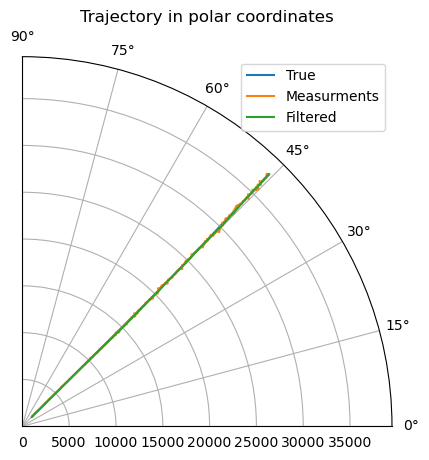

In [7]:
ax = plt.subplot(111, projection='polar')
ax.plot(Beta[0][0], D[0][0], label='True')
ax.plot(Betam1[0][0], Dm[0][0], label='Measurments')
ax.plot(Betap1[0][0], Dp1[0][0], label='Filtered')
ax.set_title('Trajectory in polar coordinates')
ax.set_xlim(0,np.radians(90))
#ax.set_ylim(0,150000)
ax.legend()

plt.show()

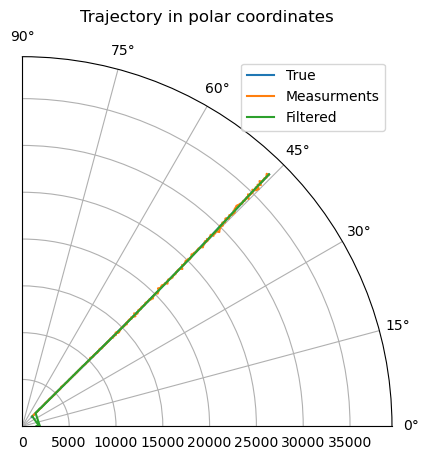

In [8]:
ax = plt.subplot(111, projection='polar')
ax.plot(Beta[0][0], D[0][0], label='True')
ax.plot(Betam1[0][0], Dm[0][0], label='Measurments')
ax.plot(Betap2[0][0], Dp1[0][0], label='Filtered')
ax.set_title('Trajectory in polar coordinates')
ax.set_xlim(0,np.radians(90))
#ax.set_ylim(25000,35000)
ax.legend()

plt.show()

In [9]:
#------------№7------------
MSE1, MSE2, MSE3, MSE4, TEE = calculate_MSE(n, M, x0, sigma_a, sigmaD, sigmaB_firstObs,sigmaB_secondObs , Fi, G, Q, X0, P0, R1,R2)

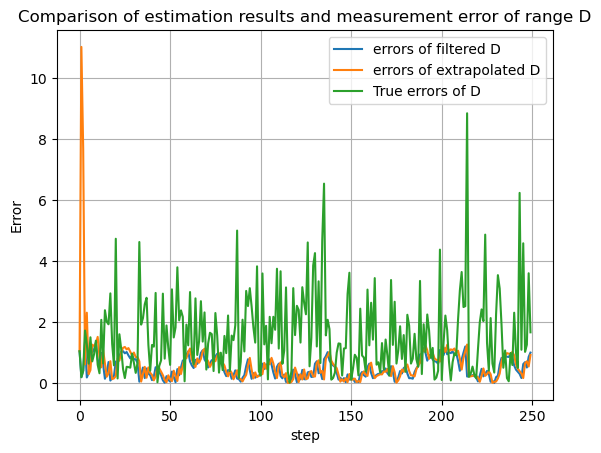

In [10]:
#------------№8------------
# Errors of extrapolation and filtration estimates of range D
plt.plot(step, MSE1[0][0], label='errors of filtered D')
plt.plot(step, MSE2[0][0], label='errors of extrapolated D')
plt.plot(step, TEE[0][0], label='True errors of D')
plt.title('Comparison of estimation results and measurement error of range D')
plt.xlabel('step')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

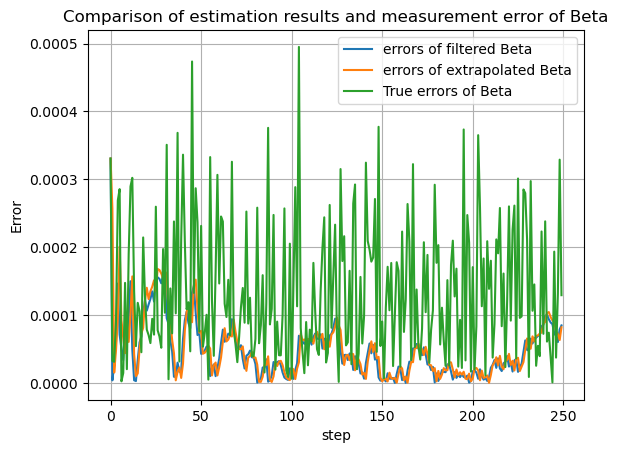

In [11]:
plt.plot(step, MSE1[0][1], label='errors of filtered Beta')
plt.plot(step, MSE2[0][1], label='errors of extrapolated Beta')
plt.plot(step, TEE[0][1], label='True errors of Beta')
plt.title('Comparison of estimation results and measurement error of Beta')
plt.xlabel('step')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()